In [ ]:
import random

class TabuGraphColoring:
    def __init__(self, G, k, tabu_tenure=7, max_iter=1000, mute =False):
        """
        G: networkx.Graph
        k: number of colors
        """
        self.G = G
        self.V = list(G.nodes)
        self.k = k
        self.tabu_tenure = tabu_tenure
        self.max_iter = max_iter
        self.it = -1
        self.reached_max_iter = False
        self.mute = mute

        # random initial coloring
        self.color = {v: random.randrange(k) for v in self.V}
        self.best_color = self.color.copy()
        self.best_conflicts = self.conflicts()

        # tabu_list[(v, color)] = expire_iter
        self.tabu_list = {}

    def conflicts(self, coloring=None):
        """Calculate the number of conflicting edges"""
        if coloring is None:
            coloring = self.color
        cnt = 0
        for u, v in self.G.edges:
            if coloring[u] == coloring[v]:
                cnt += 1
        return cnt

    def conflicting_vertices(self):
        """Return all vertices involved in conflicts"""
        bad = set()
        for u, v in self.G.edges:
            if self.color[u] == self.color[v]:
                bad.add(u)
                bad.add(v)
        return list(bad)

    def search(self):
        for it in range(self.max_iter):
            current_conflicts = self.conflicts()

            if current_conflicts == 0:
                if not self.mute:
                    print(f"✔ Found proper coloring at iteration {it}")
                self.it = it
                return self.color

            best_move = None
            best_delta = float("inf")

            conflict_vertices = self.conflicting_vertices()
            random.shuffle(conflict_vertices)

            for v in conflict_vertices:
                old_color = self.color[v]
                for c in range(self.k):
                    if c == old_color:
                        continue

                    # delta calculation: only consider neighbors of v
                    delta = 0
                    for u in self.G.neighbors(v):
                        if self.color[u] == old_color:
                            delta -= 1
                        if self.color[u] == c:
                            delta += 1

                    # tabu check
                    tabu = (v, old_color) in self.tabu_list and \
                           self.tabu_list[(v, old_color)] > it

                    # Aspiration criterion
                    if tabu and current_conflicts + delta >= self.best_conflicts:
                        continue

                    if delta < best_delta:
                        best_delta = delta
                        best_move = (v, c, old_color)

            if best_move is None:
                continue

            v, new_color, old_color = best_move
            self.color[v] = new_color
            self.tabu_list[(v, old_color)] = it + self.tabu_tenure

            new_conflicts = current_conflicts + best_delta
            if new_conflicts < self.best_conflicts:
                self.best_conflicts = new_conflicts
                self.best_color = self.color.copy()
        if not self.mute:
            print("⚠ Reached max iterations")
        self.it = self.max_iter
        self.reached_max_iter = True
        return self.best_color


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

import matplotlib.patches as mpatches


def draw_solution(G, coloring, title = "Graph Coloring (Tabu Search Result)"):

    handles = []
    for c in sorted(set(coloring.values())):
        handles.append(
            mpatches.Patch(color=plt.cm.tab10(c), label=f"Color {c}")
        )




# Generate color list in node order
    node_colors = [coloring[v] for v in G.nodes]

# layout
    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(8, 6))
    nx.draw(
        G,
        pos,
        node_color=node_colors,
        with_labels=True,
        cmap=plt.cm.tab10,
        node_size=600,
        font_color="white"
    )
    plt.legend(handles=handles, loc="best")
    plt.title(title)
    plt.show()    

In [27]:
import networkx as nx

G = nx.Graph()
G.add_edges_from([
    (0, 1), (0, 2), (1, 2),
    (1, 3), (2, 3)
])

k = 3
solver = TabuGraphColoring(G, k, tabu_tenure=5, max_iter=500)
solution = solver.search()

print("Coloring:", solution)
print("Conflicts:", solver.conflicts(solution))


✔ Found proper coloring at iteration 1
Coloring: {0: 1, 1: 0, 2: 2, 3: 1}
Conflicts: 0


✔ Found proper coloring at iteration 1
Coloring of random graph: {0: 1, 1: 0, 2: 3, 3: 3, 4: 3, 5: 0, 6: 3, 7: 1, 8: 0, 9: 2}
Conflicts in random graph coloring: 0
Conflicts Vertices in random graph coloring: []


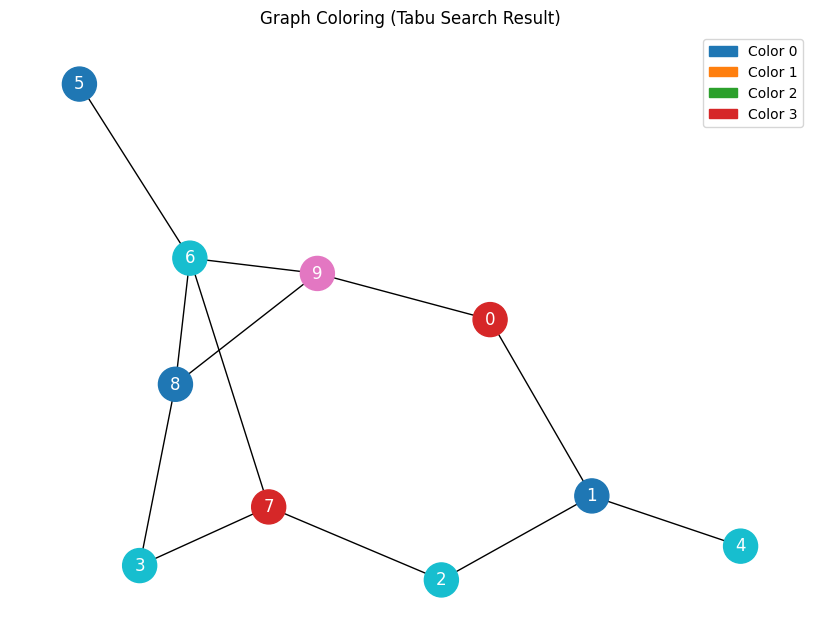

In [28]:
# Illustrative 1
randomG = nx.erdos_renyi_graph(10, 0.2)
solver2 = TabuGraphColoring(randomG, 4, tabu_tenure=5, max_iter=1000)
solution2 = solver2.search()

print("Coloring of random graph:", solution2)
print("Conflicts in random graph coloring:", solver2.conflicts(solution2))
print("Conflicts Vertices in random graph coloring:", solver2.conflicting_vertices())
draw_solution(randomG, solution2)

✔ Found proper coloring at iteration 5
Coloring of random graph: {0: 1, 1: 3, 2: 0, 3: 2, 4: 3, 5: 0, 6: 3, 7: 0, 8: 3, 9: 2, 10: 1, 11: 0, 12: 1, 13: 3, 14: 0, 15: 1, 16: 1, 17: 0, 18: 2, 19: 2}
Conflicts in random graph coloring: 0
Conflicts Vertices in random graph coloring: []


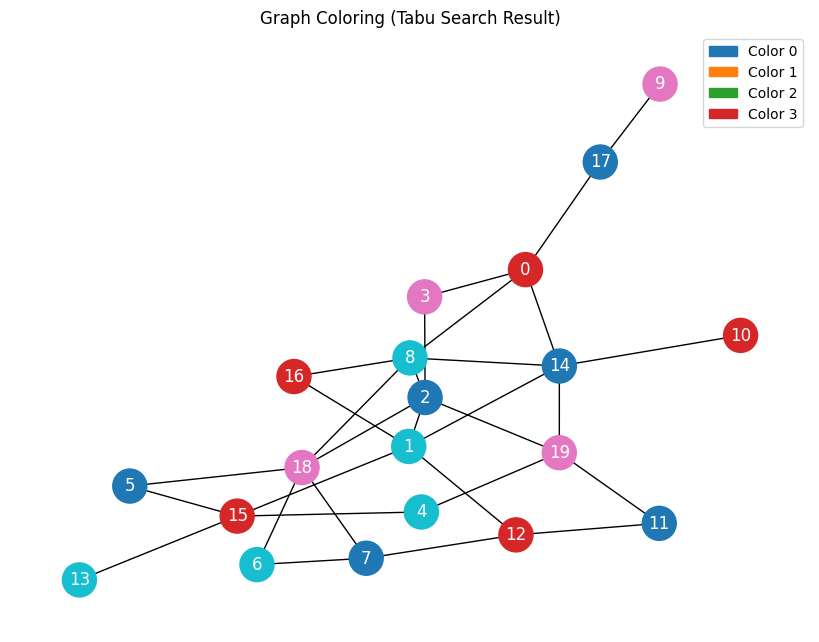

In [22]:
# Illustrative 2
randomG = nx.erdos_renyi_graph(20, 0.15)
solver2 = TabuGraphColoring(randomG, 4, tabu_tenure=5, max_iter=1000)
solution2 = solver2.search()

print("Coloring of random graph:", solution2)
print("Conflicts in random graph coloring:", solver2.conflicts(solution2))
print("Conflicts Vertices in random graph coloring:", solver2.conflicting_vertices())
draw_solution(randomG, solution2)

In [60]:
# Statistical Eval
from tqdm import tqdm
def eval(rep, n, p, colors = 4, tabu_tenure=7, max_iter=1000):
    its = []
    conflicts = []
    net_stat_edges = []
    reach_max_iters = 0
    for i in tqdm(range(rep)):
        #nit = int(n*random.uniform(0.1, 0.5))
        #pit = 0.1 + 0.4*random.random()
        randomG = nx.erdos_renyi_graph(n, p)
        net_stat_edges.append(randomG.number_of_edges()/n)
        solver2 = TabuGraphColoring(randomG, colors, tabu_tenure=tabu_tenure, max_iter=max_iter, mute=True)
        solution2 = solver2.search()
    
        if solver2.it>=0:
            its.append(solver2.it)
        if solver2.reached_max_iter:
            reach_max_iters += 1
        conflicts.append(solver2.conflicts(solution2))
    #print(f"Over {rep} runs on random graphs with 6 colors:")
    #print(f"Average edge density (edges per vertex): {sum(net_stat_edges)/rep:.2f}")
    #print(f"Average iterations to solution: {sum(its)/rep}")
    #print(f"Average conflicts in final coloring: {sum(conflicts)/rep}")
    #print(f"Number of runs that reached max iterations: {reach_max_iters}")
    return net_stat_edges, its, conflicts, reach_max_iters

    #print("Coloring of random graph:", solution2)
    #print("Conflicts in random graph coloring:", solver2.conflicts(solution2))
    #print("Conflicts Vertices in random graph coloring:", solver2.conflicting_vertices())
    #draw_solution(randomG, solution2)

In [67]:
# Eval 1, n = 50, p = 0.1, rep = 50
edge_den, its, conflicts, reach_max_iters = eval(50, 50, 0.1)
print(f"Average edge density (edges per vertex): {sum(edge_den)/len(edge_den):.2f}")
print(f"Average iterations to solution: {sum(its)/len(its):.2f}")
print(f"Average conflicts in final coloring: {sum(conflicts)/len(conflicts):.2f}")
print(f"Number of runs that reached max iterations: {reach_max_iters}")

100%|██████████| 50/50 [00:00<00:00, 59.66it/s]

Average edge density (edges per vertex): 2.45
Average iterations to solution: 104.56
Average conflicts in final coloring: 0.08
Number of runs that reached max iterations: 4


Text(0.5, 1.0, 'Histogram of Iterations to Solution')

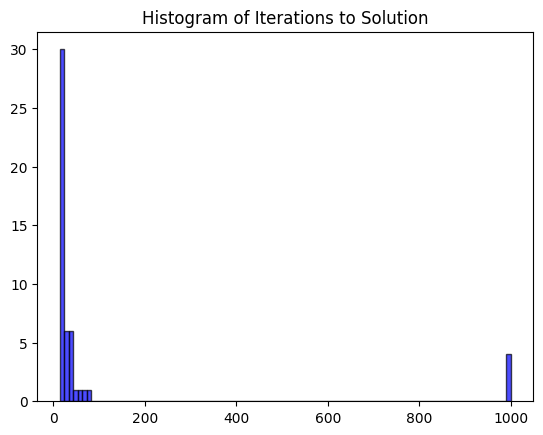

In [70]:
from matplotlib import pyplot as plt
plt.hist(its, bins=100, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of Iterations to Solution')

Text(0.5, 1.0, 'Histogram of Conflicts in Final Coloring')

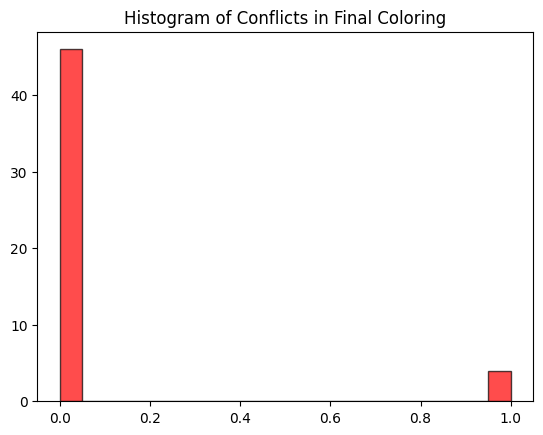

In [71]:
plt.hist(conflicts, bins=20, alpha=0.7, color='red', edgecolor='black')
plt.title('Histogram of Conflicts in Final Coloring')

In [ ]:
# Eval 2, n = 20-100, p = 0.1, rep = 50
results = {}
for n in range(20, 101, 1):
    print(f"--- Evaluating for n = {n} ---")
    edge_den, its, conflicts, reach_max_iters = eval(50, n, 0.1)
    #print(f"Average edge density (edges per vertex): {sum(edge_den)/len(edge_den):.2f}")
    #print(f"Average iterations to solution: {sum(its)/len(its):.2f}")
    #print(f"Average conflicts in final coloring: {sum(conflicts)/len(conflicts):.2f}")
    #print(f"Number of runs that reached max iterations: {reach_max_iters}")
    results[n] = {
        "edge_density": sum(edge_den)/len(edge_den),
        "avg_iterations": sum(its)/len(its) if len(its)>0 else float('inf'),
        "avg_conflicts": sum(conflicts)/len(conflicts),
        "reach_max_iters": reach_max_iters
    }



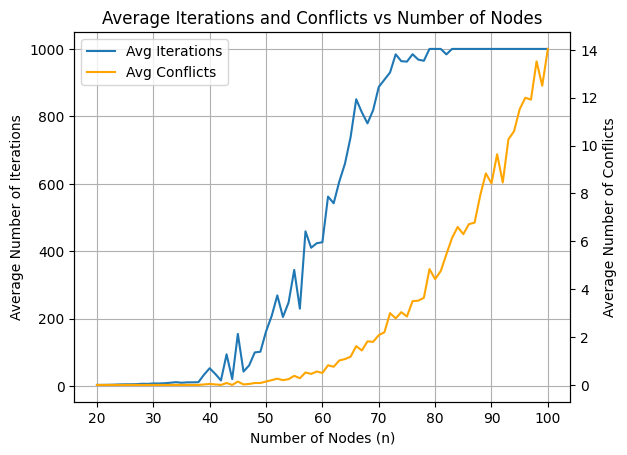

In [80]:
import matplotlib.pyplot as plt

ns = list(results.keys())
avg_iterations = [results[n]["avg_iterations"] for n in ns]
avg_conflicts = [results[n]["avg_conflicts"] for n in ns]

fig, ax1 = plt.subplots()

# left y：iterations
line1, = ax1.plot(ns, avg_iterations, label='Avg Iterations')
ax1.set_xlabel('Number of Nodes (n)')
ax1.set_ylabel('Average Number of Iterations')
ax1.grid(True)

# right y: conflicts
ax2 = ax1.twinx()
line2, = ax2.plot(ns, avg_conflicts, color='orange', label='Avg Conflicts')
ax2.set_ylabel('Average Number of Conflicts')

plt.title('Average Iterations and Conflicts vs Number of Nodes')

# merge legend
ax1.legend(handles=[line1, line2], loc='upper left')

plt.show()


Text(0.5, 1.0, 'Edge Density vs Number of Nodes')

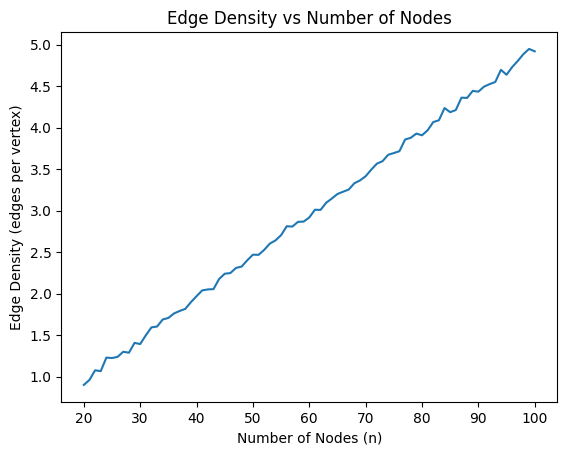

In [88]:
edges_dens = []
for n in range(20, 101, 1):
    edges = 0
    for rep in range(50):
        randomG = nx.erdos_renyi_graph(n, p = 0.1)
        edges += randomG.number_of_edges()
    edges = edges / 50
    edges_dens.append(edges/n)
plt.plot(range(20, 101), edges_dens)
plt.xlabel('Number of Nodes (n)')
plt.ylabel('Edge Density (edges per vertex)')
plt.title('Edge Density vs Number of Nodes')

In [82]:
# Eval 3, n = 50, p = 0.05 - 0.2, rep = 50
results = {}
for p in range(5, 21, 1):
    p = p / 100
    print(f"--- Evaluating for p = {p} ---")
    edge_den, its, conflicts, reach_max_iters = eval(50, 50, p)
    #print(f"Average edge density (edges per vertex): {sum(edge_den)/len(edge_den):.2f}")
    #print(f"Average iterations to solution: {sum(its)/len(its):.2f}")
    #print(f"Average conflicts in final coloring: {sum(conflicts)/len(conflicts):.2f}")
    #print(f"Number of runs that reached max iterations: {reach_max_iters}")
    results[p] = {
        "edge_density": sum(edge_den)/len(edge_den),
        "avg_iterations": sum(its)/len(its) if len(its)>0 else float('inf'),
        "avg_conflicts": sum(conflicts)/len(conflicts),
        "reach_max_iters": reach_max_iters
    }



--- Evaluating for p = 0.05 ---


100%|██████████| 50/50 [00:00<00:00, 549.45it/s]


--- Evaluating for p = 0.06 ---


100%|██████████| 50/50 [00:00<00:00, 244.22it/s]


--- Evaluating for p = 0.07 ---


100%|██████████| 50/50 [00:00<00:00, 349.64it/s]


--- Evaluating for p = 0.08 ---


100%|██████████| 50/50 [00:00<00:00, 277.78it/s]


--- Evaluating for p = 0.09 ---


100%|██████████| 50/50 [00:00<00:00, 140.45it/s]


--- Evaluating for p = 0.1 ---


100%|██████████| 50/50 [00:00<00:00, 80.59it/s]


--- Evaluating for p = 0.11 ---


100%|██████████| 50/50 [00:02<00:00, 21.89it/s]


--- Evaluating for p = 0.12 ---


100%|██████████| 50/50 [00:04<00:00, 12.49it/s]


--- Evaluating for p = 0.13 ---


100%|██████████| 50/50 [00:05<00:00,  9.64it/s]


--- Evaluating for p = 0.14 ---


100%|██████████| 50/50 [00:07<00:00,  6.40it/s]


--- Evaluating for p = 0.15 ---


100%|██████████| 50/50 [00:09<00:00,  5.29it/s]


--- Evaluating for p = 0.16 ---


100%|██████████| 50/50 [00:10<00:00,  4.75it/s]


--- Evaluating for p = 0.17 ---


100%|██████████| 50/50 [00:11<00:00,  4.20it/s]


--- Evaluating for p = 0.18 ---


100%|██████████| 50/50 [00:12<00:00,  3.89it/s]


--- Evaluating for p = 0.19 ---


100%|██████████| 50/50 [00:14<00:00,  3.54it/s]


--- Evaluating for p = 0.2 ---


100%|██████████| 50/50 [00:15<00:00,  3.29it/s]


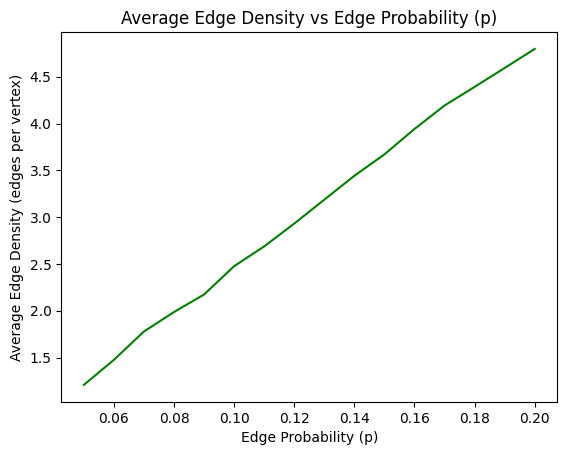

In [85]:
import matplotlib.pyplot as plt

ps = list(results.keys())
avg_iterations = [results[p]["avg_iterations"] for p in ps]
avg_conflicts = [results[p]["avg_conflicts"] for p in ps]
avg_edge_density = [results[p]["edge_density"] for p in ps]

plt.plot(ps, avg_edge_density, label='Avg Edge Density', color='green')
plt.xlabel('Edge Probability (p)')
plt.ylabel('Average Edge Density (edges per vertex)')
plt.title('Average Edge Density vs Edge Probability (p)')
plt.show()


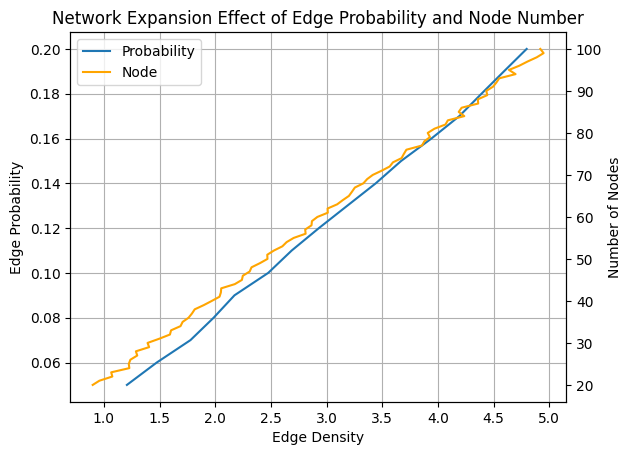

In [89]:
import matplotlib.pyplot as plt

ps = list(results.keys())
avg_iterations = [results[p]["avg_iterations"] for p in ps]
avg_conflicts = [results[p]["avg_conflicts"] for p in ps]

fig, ax1 = plt.subplots()

# left y：p
line1, = ax1.plot(avg_edge_density, ps, label='Probability')
ax1.set_xlabel('Edge Density')
ax1.set_ylabel('Edge Probability')
ax1.grid(True)

# right y: n
ax2 = ax1.twinx()
line2, = ax2.plot(edges_dens, range(20, 101), color='orange', label='Node')
ax2.set_ylabel('Number of Nodes')

plt.title('Network Expansion Effect of Edge Probability and Node Number')

# merge legend
ax1.legend(handles=[line1, line2], loc='upper left')

plt.show()


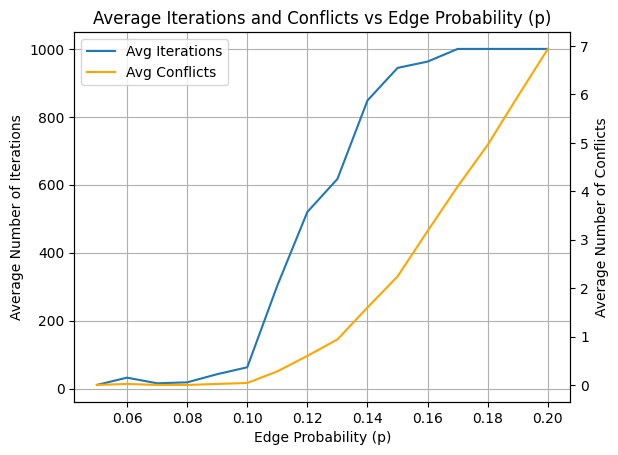

In [83]:
import matplotlib.pyplot as plt

ps = list(results.keys())
avg_iterations = [results[p]["avg_iterations"] for p in ps]
avg_conflicts = [results[p]["avg_conflicts"] for p in ps]

fig, ax1 = plt.subplots()

# left y：iterations
line1, = ax1.plot(ps, avg_iterations, label='Avg Iterations')
ax1.set_xlabel('Edge Probability (p)')
ax1.set_ylabel('Average Number of Iterations')
ax1.grid(True)

# right y: conflicts
ax2 = ax1.twinx()
line2, = ax2.plot(ps, avg_conflicts, color='orange', label='Avg Conflicts')
ax2.set_ylabel('Average Number of Conflicts')

plt.title('Average Iterations and Conflicts vs Edge Probability (p)')

# merge legend
ax1.legend(handles=[line1, line2], loc='upper left')

plt.show()


In [ ]:
# Eval 4, n = 50, p = 0.2, rep = 50, k = 3 - 7
results = {}
for k in range(3, 8, 1):
    print(f"--- Evaluating for k = {k} ---")
    edge_den, its, conflicts, reach_max_iters = eval(50, 50, 0.2, colors= k)
    #print(f"Average edge density (edges per vertex): {sum(edge_den)/len(edge_den):.2f}")
    #print(f"Average iterations to solution: {sum(its)/len(its):.2f}")
    #print(f"Average conflicts in final coloring: {sum(conflicts)/len(conflicts):.2f}")
    #print(f"Number of runs that reached max iterations: {reach_max_iters}")
    results[k] = {
        "edge_density": sum(edge_den)/len(edge_den),
        "avg_iterations": sum(its)/len(its) if len(its)>0 else float('inf'),
        "avg_conflicts": sum(conflicts)/len(conflicts),
        "reach_max_iters": reach_max_iters
    }



--- Evaluating for k = 3 ---


100%|██████████| 50/50 [00:08<00:00,  6.18it/s]


--- Evaluating for k = 4 ---


100%|██████████| 50/50 [00:00<00:00, 51.90it/s]


--- Evaluating for k = 5 ---


100%|██████████| 50/50 [00:00<00:00, 149.24it/s]


--- Evaluating for k = 6 ---


100%|██████████| 50/50 [00:00<00:00, 210.08it/s]


--- Evaluating for k = 7 ---


100%|██████████| 50/50 [00:00<00:00, 316.46it/s]


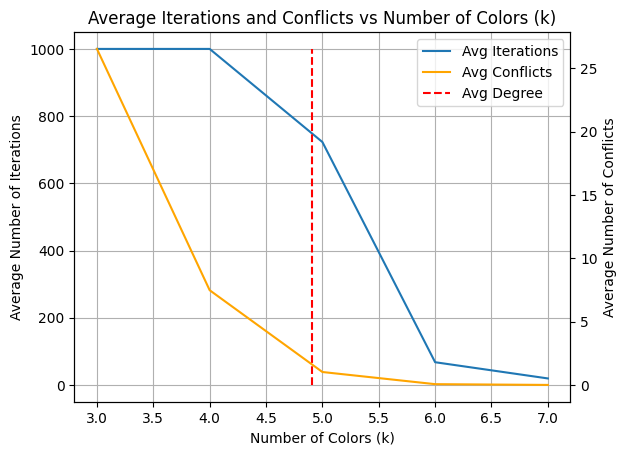

In [101]:
import matplotlib.pyplot as plt

ks = list(results.keys())
avg_iterations = [results[k]["avg_iterations"] for k in ks]
avg_conflicts = [results[k]["avg_conflicts"] for k in ks]
avg_edge_density = [results[k]["edge_density"] for k in ks]

fig, ax1 = plt.subplots()

# left y：iterations
line1, = ax1.plot(ks, avg_iterations, label='Avg Iterations')
ax1.set_xlabel('Number of Colors (k)')
ax1.set_ylabel('Average Number of Iterations')
ax1.grid(True)

# right y: conflicts
ax2 = ax1.twinx()
line2, = ax2.plot(ks, avg_conflicts, color='orange', label='Avg Conflicts')
ax2.set_ylabel('Average Number of Conflicts')

plt.title('Average Iterations and Conflicts vs Number of Colors (k)')

line3 = ax1.vlines(sum(avg_edge_density)/len(avg_edge_density), ymin=0, ymax=max(avg_iterations), colors='red', linestyles='dashed', label='Avg Degree')
#ax1.vlines(min(avg_edge_density), ymin=0, ymax=max(avg_iterations), colors='green', linestyles='dashed', label='Min Degree')
#ax1.vlines(max(avg_edge_density), ymin=0, ymax=max(avg_iterations), colors='blue', linestyles='dashed', label='Max Degree')

# merge legend
ax1.legend(handles=[line1, line2, line3], loc='upper right')



plt.show()


In [113]:
# Eval 5, n = 50, p = 0.2, rep = 50, k = 4, tabu_tenure = 3 to 7
results = {}
for tenure in range(3, 21, 1):
    print(f"--- Evaluating for tabu_tenure = {tenure} ---")
    edge_den, its, conflicts, reach_max_iters = eval(50, 50, 0.14, colors= 4, tabu_tenure=tenure)
    #print(f"Average edge density (edges per vertex): {sum(edge_den)/len(edge_den):.2f}")
    #print(f"Average iterations to solution: {sum(its)/len(its):.2f}")
    #print(f"Average conflicts in final coloring: {sum(conflicts)/len(conflicts):.2f}")
    #print(f"Number of runs that reached max iterations: {reach_max_iters}")
    results[tenure] = {
        "edge_density": sum(edge_den)/len(edge_den),
        "avg_iterations": sum(its)/len(its) if len(its)>0 else float('inf'),
        "avg_conflicts": sum(conflicts)/len(conflicts),
        "reach_max_iters": reach_max_iters
    }



--- Evaluating for tabu_tenure = 3 ---


100%|██████████| 50/50 [00:06<00:00,  7.31it/s]


--- Evaluating for tabu_tenure = 4 ---


100%|██████████| 50/50 [00:08<00:00,  5.90it/s]


--- Evaluating for tabu_tenure = 5 ---


100%|██████████| 50/50 [00:07<00:00,  7.11it/s]


--- Evaluating for tabu_tenure = 6 ---


100%|██████████| 50/50 [00:08<00:00,  5.83it/s]


--- Evaluating for tabu_tenure = 7 ---


100%|██████████| 50/50 [00:07<00:00,  6.74it/s]


--- Evaluating for tabu_tenure = 8 ---


100%|██████████| 50/50 [00:08<00:00,  6.24it/s]


--- Evaluating for tabu_tenure = 9 ---


100%|██████████| 50/50 [00:07<00:00,  6.75it/s]


--- Evaluating for tabu_tenure = 10 ---


100%|██████████| 50/50 [00:07<00:00,  6.69it/s]


--- Evaluating for tabu_tenure = 11 ---


100%|██████████| 50/50 [00:06<00:00,  7.88it/s]


--- Evaluating for tabu_tenure = 12 ---


100%|██████████| 50/50 [00:08<00:00,  5.99it/s]


--- Evaluating for tabu_tenure = 13 ---


100%|██████████| 50/50 [00:07<00:00,  6.59it/s]


--- Evaluating for tabu_tenure = 14 ---


100%|██████████| 50/50 [00:07<00:00,  6.35it/s]


--- Evaluating for tabu_tenure = 15 ---


100%|██████████| 50/50 [00:07<00:00,  7.12it/s]


--- Evaluating for tabu_tenure = 16 ---


100%|██████████| 50/50 [00:07<00:00,  6.42it/s]


--- Evaluating for tabu_tenure = 17 ---


100%|██████████| 50/50 [00:06<00:00,  7.30it/s]


--- Evaluating for tabu_tenure = 18 ---


100%|██████████| 50/50 [00:07<00:00,  7.12it/s]


--- Evaluating for tabu_tenure = 19 ---


100%|██████████| 50/50 [00:08<00:00,  5.86it/s]


--- Evaluating for tabu_tenure = 20 ---


100%|██████████| 50/50 [00:07<00:00,  6.46it/s]


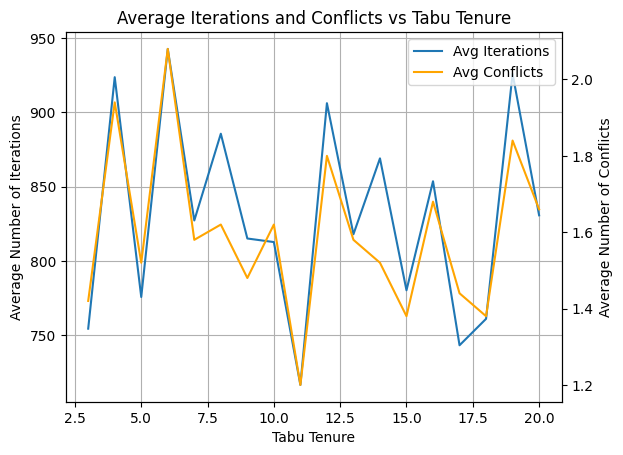

In [114]:
import matplotlib.pyplot as plt

tts = list(results.keys())
avg_iterations = [results[t]["avg_iterations"] for t in tts]
avg_conflicts = [results[t]["avg_conflicts"] for t in tts]
avg_edge_density = [results[t]["edge_density"] for t in tts]

fig, ax1 = plt.subplots()

# left y：iterations
line1, = ax1.plot(tts, avg_iterations, label='Avg Iterations')
ax1.set_xlabel('Tabu Tenure')
ax1.set_ylabel('Average Number of Iterations')
ax1.grid(True)

# right y: conflicts
ax2 = ax1.twinx()
line2, = ax2.plot(tts, avg_conflicts, color='orange', label='Avg Conflicts')
ax2.set_ylabel('Average Number of Conflicts')

plt.title('Average Iterations and Conflicts vs Tabu Tenure')
#line3 = ax1.vlines(sum(avg_edge_density)/len(avg_edge_density), ymin=0, ymax=max(avg_iterations), colors='red', linestyles='dashed', label='Avg Degree')
#ax1.vlines(min(avg_edge_density), ymin=0, ymax=max(avg_iterations), colors='green', linestyles='dashed', label='Min Degree')
#ax1.vlines(max(avg_edge_density), ymin=0, ymax=max(avg_iterations), colors='blue', linestyles='dashed', label='Max Degree')

# merge legend
ax1.legend(handles=[line1, line2], loc='upper right')



plt.show()


✔ Found proper coloring at iteration 7
Coloring of random graph: {(0, 0): 1, (0, 1): 0, (0, 2): 1, (0, 3): 2, (0, 4): 0, (0, 5): 1, (1, 0): 2, (1, 1): 1, (1, 2): 0, (1, 3): 3, (1, 4): 1, (1, 5): 2, (2, 0): 0, (2, 1): 3, (2, 2): 2, (2, 3): 1, (2, 4): 0, (2, 5): 3, (3, 0): 2, (3, 1): 1, (3, 2): 3, (3, 3): 2, (3, 4): 3, (3, 5): 1, (4, 0): 0, (4, 1): 2, (4, 2): 0, (4, 3): 1, (4, 4): 2, (4, 5): 0, (5, 0): 1, (5, 1): 3, (5, 2): 1, (5, 3): 0, (5, 4): 3, (5, 5): 2}
Conflicts in random graph coloring: 0
Conflicts Vertices in random graph coloring: []


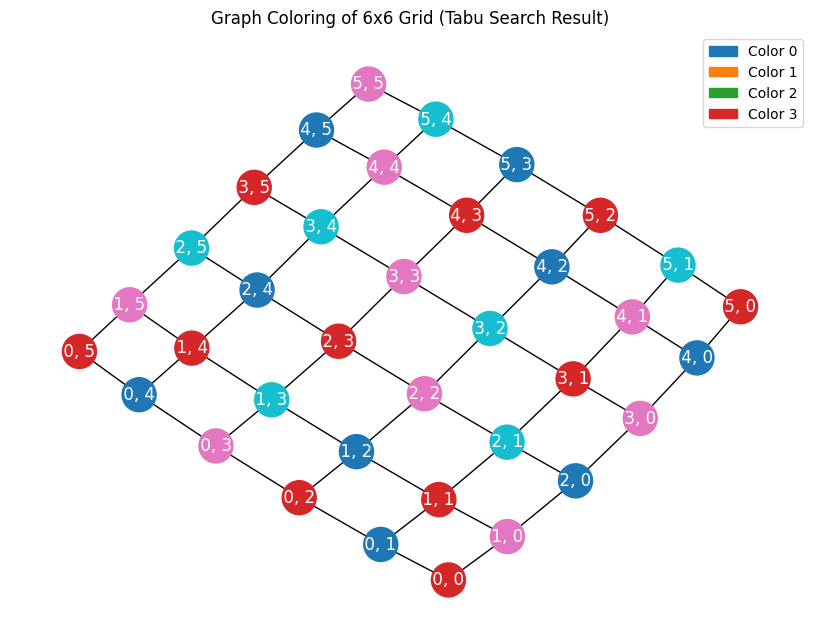

In [5]:
G = nx.grid_2d_graph(6, 6)
solver3 = TabuGraphColoring(G, 4, tabu_tenure=5, max_iter=1000)
solution3 = solver3.search()

print("Coloring of random graph:", solution3)
print("Conflicts in random graph coloring:", solver3.conflicts(solution3))
print("Conflicts Vertices in random graph coloring:", solver3.conflicting_vertices())
draw_solution(G, solution3, title="Graph Coloring of 6x6 Grid (Tabu Search Result)")